# Iris Flower Classification using Machine Learning

The workflow for the Iris classification problem:
1. Load data and quick EDA  
2. Preprocessing with scikit-learn Pipeline  
3. Model comparison with cross-validation  
4. Hyperparameter tuning example (Random Forest)  
5. Final evaluation and model persistence  


In [ ]:
# Step 1 — Imports necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

RANDOM_STATE = 42


In [ ]:
# Step 2 — Load dataset and quick EDA
data = load_iris(as_frame=True)
df = data.frame.copy()   # feature columns + target
df['target'] = data.target

# Quick checks
print('Shape:', df.shape)
print('Statistical Summary:', df.describe())
print('\nClass distribution:')
print(df['target'].value_counts(sort=False))

# show first 5 rows 
df.head()


Shape: (150, 5)
Statistical Summary:        sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  

Class distribution:
target
0    50

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
# Step 3 — Preprocessing and train/test split
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [4]:
# Step 4 — Define model pipelines to compare
models = {
    'logreg': Pipeline([('preproc', numeric_pipeline),
                        ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))]),
    'rf': Pipeline([('preproc', numeric_pipeline),
                    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))]),
    'svc': Pipeline([('preproc', numeric_pipeline),
                     ('clf', SVC(probability=True, random_state=RANDOM_STATE))]),
}


In [5]:
# Step 5 — Quick cross-validation to compare algorithms
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name:6s} — mean accuracy: {scores.mean():.3f}  (std: {scores.std():.3f})")


logreg — mean accuracy: 0.958  (std: 0.026)
rf     — mean accuracy: 0.950  (std: 0.031)
svc    — mean accuracy: 0.967  (std: 0.017)


In [6]:
# Step 6 — Hyperparameter tuning example for RandomForest
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 3, 5, 10],
    'clf__min_samples_split': [2, 4, 8]
}

gs = GridSearchCV(models['rf'], param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)

print('Best params:', gs.best_params_)
print('Best CV score:', gs.best_score_)

best_model = gs.best_estimator_


Best params: {'clf__max_depth': None, 'clf__min_samples_split': 4, 'clf__n_estimators': 50}
Best CV score: 0.9666666666666668


Test accuracy: 0.9333333333333333

Classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



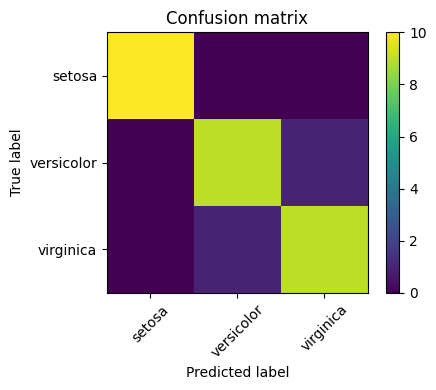

In [7]:
# Step 7 — Evaluation on the test set
y_pred = best_model.predict(X_test)

print('Test accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test, y_pred, target_names=data.target_names))

cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix with matplotlib (one plot — no seaborn)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
plt.xticks(range(len(data.target_names)), data.target_names, rotation=45)
plt.yticks(range(len(data.target_names)), data.target_names)
plt.tight_layout()
plt.show()


In [8]:
# Step 8 — Persist the best model for later use
model_filename = 'iris_best_model.joblib'
joblib.dump(best_model, model_filename)
print(f'Model saved to {model_filename}')


Model saved to iris_best_model.joblib
